In [11]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

## 认识数据集

In [37]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15, 15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

In [34]:
# https://github.com/pytorch/vision/issues/7545
data = torchvision.datasets.StanfordCars('../data/')

In [38]:
len(data)

8144

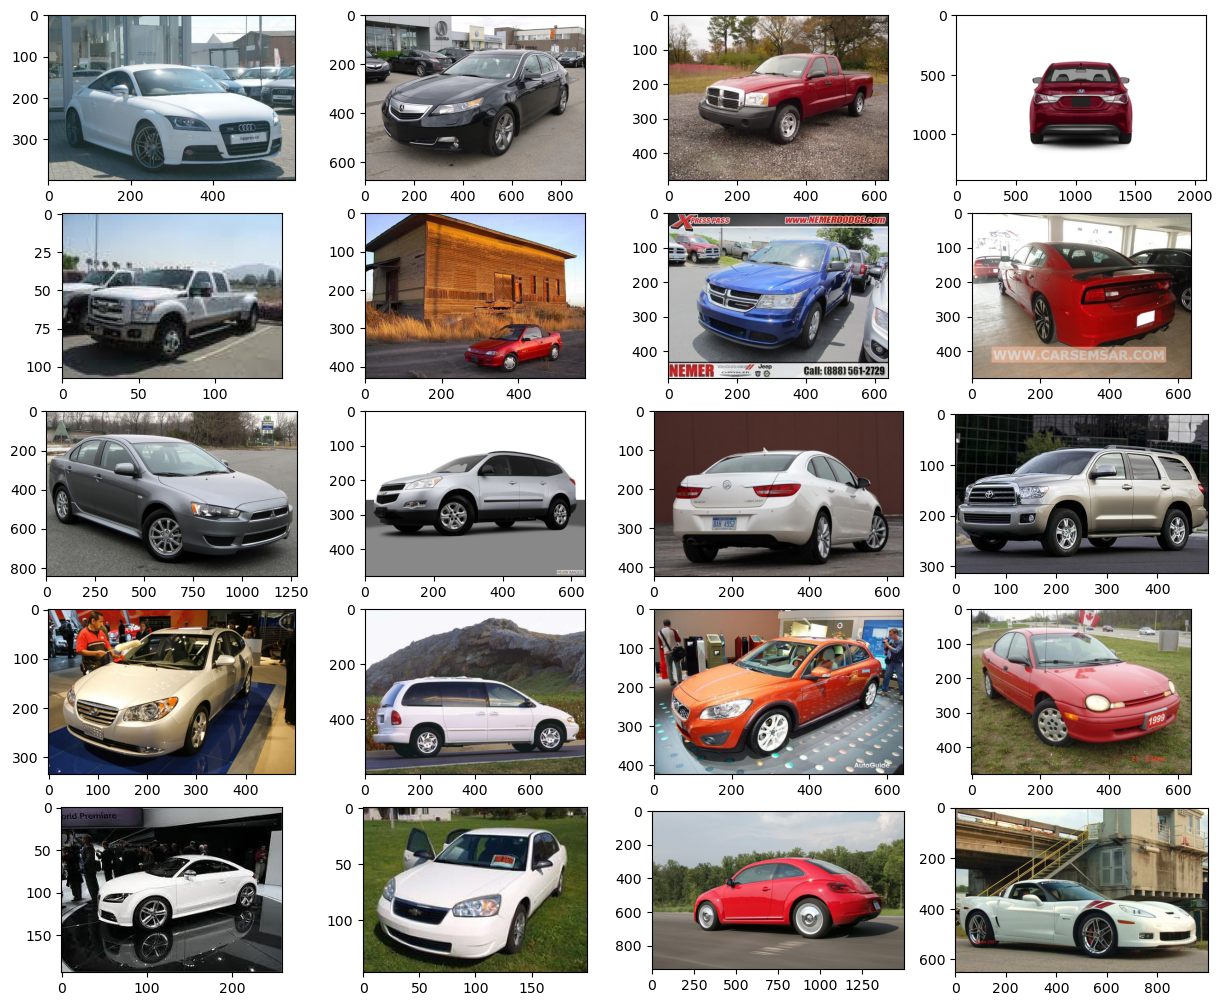

In [36]:
show_images(data)

In [61]:
from torchvision import transforms as T 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    
    data_transform = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.RandomHorizontalFlip(),
        T.ToTensor(), # Scales data into [0,1] 
        T.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ])

    train = torchvision.datasets.StanfordCars(root="../data/", 
                                              transform=data_transform)

    test = torchvision.datasets.StanfordCars(root="../data/", 
                                             transform=data_transform, 
                                             split='test')
    
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = T.Compose([
        T.Lambda(lambda t: (t + 1) / 2),
        T.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        T.Lambda(lambda t: t * 255.),
        T.Lambda(lambda t: t.numpy().astype(np.uint8)),
        T.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))



In [66]:
dataset = load_transformed_dataset()
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [73]:
len(dataloader) == len(dataset)//BATCH_SIZE

True

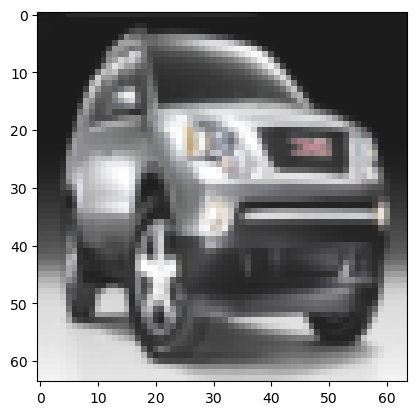

In [65]:
show_tensor_image(next(iter(dataloader))[0])

## Step 1: The forward process = Noise scheduler

$$
\alpha_t=1-\beta_t\\
\bar\alpha_t=\Pi_{i=1}^t\alpha_i\\
q(x_t|x_0)=\mathcal N(x_t;\sqrt{\bar\alpha_t}x_0,(1-\bar\alpha_t)I)\\
x_t=\sqrt{\bar\alpha_t}x_0,(1-\bar\alpha_t)I
$$

In [39]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

In [48]:
def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [40]:
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

In [46]:
# https://blog.csdn.net/jorg_zhao/article/details/105295686
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

In [47]:
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)